In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Use the correct path (e.g., '/content/your_model.keras' if uploaded to sidebar)
model_path = '/content/final_brain_multi_disease_model (1).keras'
model = tf.keras.models.load_model(model_path)

print("Model loaded successfully!")
model.summary()

Model loaded successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,954 (9.87 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 164,486 (642.53 KB)

Prediction: Tumor_Positive (99.58%)


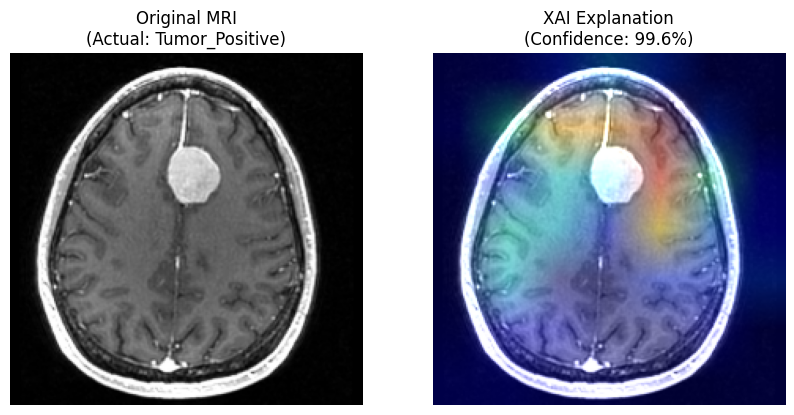

In [ ]:
import cv2

# XAI Functions (Grad-CAM)
def make_gradcam_heatmap(img_array, model):
    # Access the backbone (MobileNetV2) inside the Sequential model
    backbone = model.layers[0]
    last_conv_layer = backbone.layers[-1]

    # Model that maps input to the last conv layer + backbone output
    intermediate_model = tf.keras.models.Model(
        [backbone.input], [last_conv_layer.output, backbone.output]
    )

    with tf.GradientTape() as tape:
        conv_output, backbone_top = intermediate_model(img_array)

        # Pass backbone output through your custom top layers
        x = model.layers[1](backbone_top) # GlobalAveragePooling2D
        x = model.layers[2](x) # Dense
        x = model.layers[3](x) # Dropout
        preds = model.layers[4](x) # Final Dense

        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calculate gradients and pooled gradients
    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the channels of the feature map
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load original image for overlay
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use 'jet' colormap
    jet = plt.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Resize heatmap to match original image
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    jet_heatmap = np.uint8(255 * jet_heatmap)

    # Superimpose
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return img, superimposed_img

def prepare_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array / 255.0

# --- EXECUTION ---

# 1. Path to your test image
test_img_path = '/content/Screenshot 2026-01-09 201445.png'

# 2. Get Prediction
processed_img = prepare_image(test_img_path)
predictions = model.predict(processed_img, verbose=0)
class_names = ['Alzheimers_Positive', 'Healthy', 'MS_Positive', 'Tumor_Positive']
result = class_names[np.argmax(predictions)]
confidence = np.max(predictions) * 100

print(f"Prediction: {result} ({confidence:.2f}%)")

# 3. Generate XAI Heatmap
heatmap = make_gradcam_heatmap(processed_img, model)
original, xai_result = display_gradcam(test_img_path, heatmap)

# 4. Plot Side-by-Side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title(f"Original MRI\n(Actual: {result})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(xai_result)
plt.title(f"XAI Explanation\n(Confidence: {confidence:.1f}%)")
plt.axis("off")

plt.show()